In [1]:
# Do imports
import re
import os
import math
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
from adjustText import adjust_text
from dcor import distance_correlation
from sklearn.decomposition import PCA
import anndata
import scipy.io

In [3]:
# Load in the data and ensure that the metadata mappings are accurate
data_dir = "../../data"

In [ ]:
data = sc.read_h5ad(os.path.join(data_dir, "simplified_seurat.h5ad"))
data

In [ ]:
# Filter out for source and radiation condition
source = "preinf"
condition = "noRT"
subset_data = data[data.obs.sourceCond == f"{source}_{condition}"]
subset_data

In [ ]:
# Run QC on this subset of data
subset_data.var['mt'] = subset_data.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(subset_data, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)
sc.pl.violin(subset_data, ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt'], stripplot=False, multi_panel=True)

In [183]:
# Filter cells
from pyturbseq.utils import filter_adata

subset_data = filter_adata(
    subset_data,
    obs_filters=[
        "n_genes_by_counts > 2000",
        "pct_counts_mt < 20",
        "total_counts > 6000",
    ],
    var_filters=[
        'n_cells_by_counts > 50',
        'total_counts > 100'
    ]
    )
subset_data

View of AnnData object with n_obs × n_vars = 15552 × 12780
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'source', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'scMRMA', 'scMRMA_manual', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sourceCond', 'sgRNACond', 'double', 'percent_mt', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'

In [184]:
# Do a coverage check for each sgRNA. We will eliminate any sgRNA from consideration
# that doesn't have at least 5 cells in both single and combination
mask = subset_data.obs.sgRNA.str.contains("_")
combinations = subset_data.obs.sgRNA[mask]
sgRNAs_to_keep = ["non-targeting"] # Keep non-targeting by default for normalization
sgRNA_counts = subset_data.obs.sgRNA.value_counts()
for combination in combinations:
    geneA = combination.split("_")[0]
    geneB = combination.split("_")[1]
    if sgRNA_counts[combination].item() > 5 and sgRNA_counts[geneA].item() > 5 and sgRNA_counts[geneB].item() > 5:
        sgRNAs_to_keep.extend([geneA, geneB, combination])
subset_data = subset_data[subset_data.obs.sgRNA.isin(sgRNAs_to_keep)].copy()
subset_data

AnnData object with n_obs × n_vars = 15167 × 12780
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'source', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'scMRMA', 'scMRMA_manual', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sourceCond', 'sgRNACond', 'double', 'percent_mt', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'

In [185]:
# Equalize counts and log transform

# We will normalize everything to the control median
control_group = subset_data[subset_data.obs.sgRNA == "non-targeting"]
median_UMI_level_for_control_group = np.median(control_group.X.toarray().sum(axis=1))

# Scale all cells by the median of the control group divided by the sum of UMI for that cell
total_reads_per_cell = subset_data.X.toarray().sum(axis=1)
sc.pp.normalize_total(subset_data, target_sum=median_UMI_level_for_control_group)
sc.pp.log1p(subset_data)

In [186]:
# Z-normalize the data around the control group. That means the coordinate system will then be centered at the all-0
# vector, which also represents the mean control cell, any deviation is theoretically due to perturbations and not
# anything else. If the standard deviation is 0, substitute a minimum threshold SD.

control_group = subset_data[subset_data.obs.sgRNA == "non-targeting"]
control_group_mean = control_group.X.mean(axis=0)
control_group_std = np.std(control_group.X.toarray(), axis = 0)
min_std = 0.1 * np.median(control_group_std[control_group_std > 0])
control_group_std_corrected = np.maximum(control_group_std, min_std)

X = subset_data.X.toarray()
mean_corrected_x = X - control_group_mean
normalized_x = mean_corrected_x / control_group_std_corrected

In [187]:
# Convert X back into a sparse matrix and assign it to the subset data
subset_data.X = csr_matrix(normalized_x)

In [190]:
# Filter for only genes with an average UMI count across cells of > 0.01
# gene_means = subset_data.X.mean(axis=0)
# mask = gene_means > 0.01
# subset_data_filtered = subset_data[:, mask]
subset_data_filtered = subset_data
subset_data_filtered

AnnData object with n_obs × n_vars = 15167 × 12780
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'source', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'scMRMA', 'scMRMA_manual', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sourceCond', 'sgRNACond', 'double', 'percent_mt', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    uns: 'log1p'

In [191]:
# For each sgRNA, retrieve a pseudobulked expression profile by averaging the cells across genes
sgRNAs = pd.unique(subset_data_filtered.obs.sgRNA)
pseudobulked_expression_vectors = {}
for sgRNA in sgRNAs:
    sgRNA_subset = subset_data_filtered[subset_data_filtered.obs.sgRNA == sgRNA]
    expression_matrix = sgRNA_subset.X
    average_expression_vector = expression_matrix.toarray().mean(axis=0)
    pseudobulked_expression_vectors[sgRNA] = average_expression_vector
pseudobulked_expression_vectors

{'Ifnar1': array([-0.11260884,  0.07936059, -0.21435277, ...,  0.12539511,
         0.00423235,  0.08249409]),
 'Fanca': array([-0.06621569,  0.07717425, -0.09098473, ...,  0.01089558,
         0.0552261 , -0.02171096]),
 'Cdkn1a': array([-0.05789501,  0.03820031,  0.14599209, ...,  0.01194093,
         0.13071757,  0.1600733 ]),
 'Nat2': array([-2.94859811e-02,  1.47390343e-01,  7.74381922e-03, ...,
         5.82105854e-05,  1.50551168e-01,  7.53409305e-02]),
 'Dclre1c': array([-0.10230751,  0.04381913, -0.017754  , ...,  0.03354326,
         0.10882103,  0.28583046]),
 'Trp53bp1': array([-0.12845719,  0.02642499, -0.07308843, ...,  0.10127429,
         0.11589517,  0.13636416]),
 'Xrcc3': array([-0.17154676,  0.04838343, -0.00826957, ...,  0.2528552 ,
         0.10644488, -0.08471265]),
 'Cdkn2a': array([-0.10722659,  0.06469597, -0.04743535, ...,  0.01965623,
         0.00960459,  0.09049799]),
 'Cyp19a1': array([-0.19135866,  0.01962241,  0.01765574, ...,  0.05367408,
        -0.00

In [192]:
for sgRNA, vector in pseudobulked_expression_vectors.items():
    print(f"{sgRNA}: non-zero: {np.sum(vector != 0)}, min: {np.min(vector)}, max: {np.max(vector)}")

Ifnar1: non-zero: 12780, min: -2.259428087246072, max: 0.7122259614347539
Fanca: non-zero: 12780, min: -0.5493303222240512, max: 0.838688257041089
Cdkn1a: non-zero: 12780, min: -1.1257189922925004, max: 0.7170246332312249
Nat2: non-zero: 12780, min: -0.3869334793092761, max: 0.7499795191969176
Dclre1c: non-zero: 12780, min: -0.2964778458986305, max: 0.7884569987328697
Trp53bp1: non-zero: 12780, min: -0.516784740943169, max: 1.9342983478531401
Xrcc3: non-zero: 12779, min: -0.5158160930784862, max: 1.733405336611567
Cdkn2a: non-zero: 12780, min: -1.5957624052274482, max: 0.7597673844107359
Cyp19a1: non-zero: 12779, min: -0.39555489448158077, max: 0.7101226805631862
non-targeting: non-zero: 12773, min: -4.516992087166164e-14, max: 2.926412779662073e-14
Rad21: non-zero: 12779, min: -1.3344767310209813, max: 2.5214937349012225
Eif2s1: non-zero: 12780, min: -1.3271840024197028, max: 0.9240399391736573
Lig4: non-zero: 12780, min: -0.7463398565413172, max: 1.2201920898209484
Xrcc5: non-zero: 1

In [193]:
# Linear modeling class

class LinearModel:
    
    def __init__(self):
        self.X = None
        self.y = None
        self.model = None
        self.c1 = None
        self.c2 = None
        self.R2 = None
        self.predicted_y = None
        self.error_term = None
        self.error_term_l2_norm = None
        self.dominance = None
        self.magnitude = None
        self.dcor_predicted_actual = None
        self.dcor_X_predicted = None
        self.dcor_x1_x2 = None
        self.equality_of_contribution = None

    def fit_model(self, X, y, type = "TS"):
        self.X = X
        self.y = y
        if type == "TS":
            self._fit_theil_sein_model()
        elif type == "OLS":
            self._fit_ols_model()
        else:
            print("Not implemented yet!")

    def _fit_theil_sein_model(self):
        model = linear_model.TheilSenRegressor(
            fit_intercept=False,
            max_subpopulation=1e5,
            max_iter=1000,
            random_state=1000
        )
        model.fit(self.X, self.y)
        self.model = model
        self.c1 = model.coef_[0]
        self.c2 = model.coef_[1]
        self.R2 = model.score(self.X, self.y)
        self.predicted_y = model.predict(self.X)
        self.error_term = self.predicted_y - self.y
        self.error_term_l2_norm = np.linalg.norm(model.predict(self.X) - self.y)
        self.dominance = abs(math.log(abs(self.c1 / self.c2), 10))
        self.magnitude = (self.c1 ** 2 + self.c2 ** 2) ** 0.5
        self.dcor_predicted_actual = distance_correlation(self.predicted_y, self.y)
        self.dcor_X_predicted = distance_correlation(self.X, self.predicted_y)
        self.dcor_x1_x2 = distance_correlation(self.X[:, 0], self.X[:, 1])

        dcor_x1_predicted = distance_correlation(self.X[:, 0], self.predicted_y)
        dcor_x2_predicted = distance_correlation(self.X[:, 1], self.predicted_y)
        self.equality_of_contribution = min(dcor_x1_predicted, dcor_x2_predicted) / max(dcor_x1_predicted, dcor_x2_predicted)

    def _fit_ols_model(self):
        model = linear_model.LinearRegression(fit_intercept=False)
        model.fit(self.X, self.y)
        self.model = model
        self.c1 = model.coef_[0]
        self.c2 = model.coef_[1]
        self.R2 = model.score(self.X, self.y)
        self.predicted_y = model.predict(self.X)
        self.error_term = self.predicted_y - self.y
        self.error_term_l2_norm = np.linalg.norm(model.predict(self.X) - self.y)
        self.dominance = abs(math.log(abs(self.c1 / self.c2), 10))
        self.magnitude = (self.c1 ** 2 + self.c2 ** 2) ** 0.5
        self.dcor_predicted_actual = distance_correlation(self.predicted_y, self.y)
        self.dcor_X_predicted = distance_correlation(self.X, self.predicted_y)
        self.dcor_x1_x2 = distance_correlation(self.X[:, 0], self.X[:, 1])

        dcor_x1_predicted = distance_correlation(self.X[:, 0], self.predicted_y)
        dcor_x2_predicted = distance_correlation(self.X[:, 1], self.predicted_y)
        self.equality_of_contribution = min(dcor_x1_predicted, dcor_x2_predicted) / max(dcor_x1_predicted, dcor_x2_predicted)

In [194]:
# Generate a linear model for each set of double perturbations
mask = subset_data_filtered.obs.sgRNA.str.contains("_")
combinations = pd.unique(subset_data.obs.sgRNA[mask])

modeling_results_dict = {}
for sgRNA in combinations:
    print(f"Generating model for {sgRNA}...")
    perturb_A = sgRNA.split("_")[0]
    perturb_B = sgRNA.split("_")[1]
    perturbA_vector = pseudobulked_expression_vectors[perturb_A].reshape([-1, 1])
    perturbB_vector = pseudobulked_expression_vectors[perturb_B].reshape([-1, 1])
    combination_vector = pseudobulked_expression_vectors[sgRNA]
    X = np.column_stack([perturbA_vector, perturbB_vector])
    y = combination_vector
    theil_sen_linear_model = LinearModel()
    theil_sen_linear_model.fit_model(X, y)
    ols = LinearModel()
    ols.fit_model(X, y, type = "OLS")
    modeling_results_dict[sgRNA] = {
        "TS": theil_sen_linear_model,
        "OLS": ols
    }

Generating model for Cdkn2a_Mre11a...
Generating model for Ifnar1_Fanca...
Generating model for Ifnar1_Nat2...
Generating model for Cdkn1a_Xrcc5...
Generating model for Cdkn2a_Ifnar1...
Generating model for Cdkn2a_Cdkn1a...
Generating model for Ifnar1_Sel1l...
Generating model for Ifnar1_Xrcc5...
Generating model for Cdkn1a_Nat2...
Generating model for Cdkn2a_Cyp19a1...
Generating model for Ifnar1_Abtb1...
Generating model for Cdkn2a_Sel1l...
Generating model for Xrcc3_Lig4...
Generating model for Ifnar1_Prkdc...
Generating model for Cdkn1a_Ifnar1...
Generating model for Cdkn2a_Fanca...
Generating model for Ifnar1_Sass6...
Generating model for Cdkn2a_Trp53bp1...
Generating model for Ifnar1_Rad21...
Generating model for Ifnar1_Shc1...
Generating model for Cyp19a1_Sel1l...
Generating model for Cdkn2a_Nat2...
Generating model for Cdkn2a_Ercc4...
Generating model for Ifnar1_Dclre1c...
Generating model for Cdkn2a_Shc1...
Generating model for Cdkn1a_Sel1l...
Generating model for Ifnar1_Trp53

In [195]:
# Prepare for outputs
output_dir = "../../output/coefficient_analysis"

In [196]:
# Collect the coefficients into a dataframe for plotting and save it
results_data = []
for sgRNA, modeling_result in modeling_results_dict.items():
    row = modeling_result["OLS"].__dict__
    row["sgRNA"] = sgRNA
    results_data.append(row)
results_df = pd.DataFrame(results_data)
results_df.set_index('sgRNA', inplace=True)
results_df.to_csv(os.path.join(output_dir, "results_df.csv"))
results_df

X  \
sgRNA                                                                
Cdkn2a_Mre11a    [[-0.10722658844082415, -0.2727971948490484], ...   
Ifnar1_Fanca     [[-0.11260883604906052, -0.06621568820055006],...   
Ifnar1_Nat2      [[-0.11260883604906052, -0.029485981100407795]...   
Cdkn1a_Xrcc5     [[-0.05789501124369396, -0.005593538337752723]...   
Cdkn2a_Ifnar1    [[-0.10722658844082415, -0.11260883604906052],...   
Cdkn2a_Cdkn1a    [[-0.10722658844082415, -0.05789501124369396],...   
Ifnar1_Sel1l     [[-0.11260883604906052, -0.0670199226431648], ...   
Ifnar1_Xrcc5     [[-0.11260883604906052, -0.005593538337752723]...   
Cdkn1a_Nat2      [[-0.05789501124369396, -0.029485981100407795]...   
Cdkn2a_Cyp19a1   [[-0.10722658844082415, -0.19135865542489802],...   
Ifnar1_Abtb1     [[-0.11260883604906052, -0.06416700003071622],...   
Cdkn2a_Sel1l     [[-0.10722658844082415, -0.0670199226431648], ...   
Xrcc3_Lig4       [[-0.17154675914439904, 0.12432518047094228], ...   
Ifnar1_Prkdc     [[-0.11260883604906052, -0.06861676016023024],...   
Cdkn1a_Ifnar1    [[-0.05789501124369396, -0.11260883604906052],...   
Cdkn2a_Fanca     [[-0.10722658844082415, -0.06621568820055006],...   
Ifnar1_Sass6     [[-0.11260883604906052, -0.14637239089145232],...   
Cdkn2a_Trp53bp1  [[-0.10722658844082415, -0.1284571865255052], ...   
Ifnar1_Rad21     [[-0.11260883604906052, 0.005888139194860059],...   
Ifnar1_Shc1      [[-0.11260883604906052, 0.046938639112027135],...   
Cyp19a1_Sel1l    [[-0.19135865542489802, -0.0670199226431648], ...   
Cdkn2a_Nat2      [[-0.10722658844082415, -0.029485981100407795]...   
Cdkn2a_Ercc4     [[-0.10722658844082415, -0.11605533571078268],...   
Ifnar1_Dclre1c   [[-0.11260883604906052, -0.10230750899018277],...   
Cdkn2a_Shc1      [[-0.10722658844082415, 0.046938639112027135],...   
Cdkn1a_Sel1l     [[-0.05789501124369396, -0.0670199226431648], ...   
Ifnar1_Trp53bp1  [[-0.11260883604906052, -0.1284571865255052], ...   
Ifnar1_Ercc4     [[-0.11260883604906052, -0.11605533571078268],...   
Cdkn2a_Rad21     [[-0.10722658844082415, 0.005888139194860059],...   
Cdkn2a_Abtb1     [[-0.10722658844082415, -0.06416700003071622],...   
Ifnar1_Cyp19a1   [[-0.11260883604906052, -0.19135865542489802],...   
Ifnar1_Eif2s1    [[-0.11260883604906052, -0.0030105918295007957...   
Ifnar1_Lig4      [[-0.11260883604906052, 0.12432518047094228], ...   
Cdkn1a_Fanca     [[-0.05789501124369396, -0.06621568820055006],...   
Ifnar1_Bard1     [[-0.11260883604906052, -0.10080828971479579],...   
Cdkn1a_Abtb1     [[-0.05789501124369396, -0.06416700003071622],...   

                                                                 y  \
sgRNA                                                                
Cdkn2a_Mre11a    [-0.24546894103306777, -0.09650082374989119, -...   
Ifnar1_Fanca     [-0.2949900895505573, 0.5652162473066386, -0.3...   
Ifnar1_Nat2      [0.042566015875488326, 0.20587835879693991, -0...   
Cdkn1a_Xrcc5     [0.38798432862692955, -0.11058723157247505, -0...   
Cdkn2a_Ifnar1    [-0.11165020021540199, 0.14321422238614714, -0...   
Cdkn2a_Cdkn1a    [0.032980970754189855, 0.25315733528818846, 0....   
Ifnar1_Sel1l     [-0.13812204985355211, -0.12416571935794302, 0...   
Ifnar1_Xrcc5     [0.17264673950087484, 0.04171547523937106, 0.0...   
Cdkn1a_Nat2      [-0.25018764688912515, 0.7551334712039841, 0.4...   
Cdkn2a_Cyp19a1   [-0.2747249311686459, -0.5611531004891964, -0....   
Ifnar1_Abtb1     [0.16292163188241598, 0.10925135815874927, -0....   
Cdkn2a_Sel1l     [-0.0030469559651050294, 0.15158876370159438, ...   
Xrcc3_Lig4       [-0.4441010095318254, -0.13632109986279603, -0...   
Ifnar1_Prkdc     [0.5176475462809721, -0.008536666684112336, -0...   
Cdkn1a_Ifnar1    [0.2261019167527376, -0.07738832228981159, 0.1...   
Cdkn2a_Fanca     [0.12831913013691176, -0.0005861051736830714, ...   
Ifnar1_Sass6     [0.18998055978471343, 0.05336904112887334, -0....   
Cdkn2a_Trp53bp1  [-0.16151684084278953, 0.7073325764566784, 0.1...   
Ifna

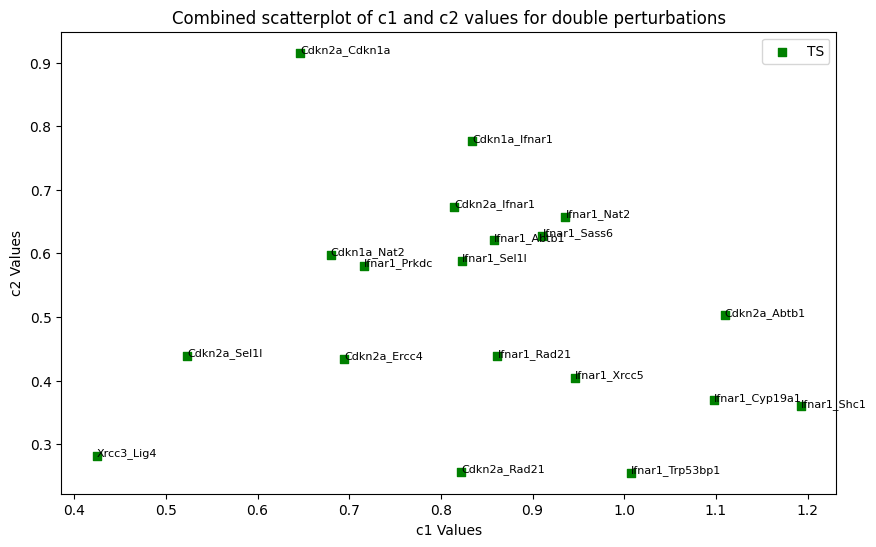

In [120]:
# Make a scatterplot of the coefficients
def plot_combined_scatter(df):
    plt.figure(figsize=(10, 6))
    # points_ols = plt.scatter(df['c1_ols'], df['c2_ols'], color='red', marker='o', label='OLS')
    # points_tukey = plt.scatter(df['c1_tukey_biweight'], df['c2_tukey_biweight'], color='blue', marker='^', label='Tukey Biweight')
    points_ts = plt.scatter(df['c1'], df['c2'], color='green', marker='s', label='TS')
    
    texts = []
    for idx in df.index:
        # texts.append(plt.text(df.loc[idx, 'c1_ols'], df.loc[idx, 'c2_ols'], idx, color='black', fontsize=8))
        # texts.append(plt.text(df.loc[idx, 'c1_tukey_biweight'], df.loc[idx, 'c2_tukey_biweight'], idx, color='black', fontsize=8))
        texts.append(plt.text(df.loc[idx, 'c1'], df.loc[idx, 'c2'], idx, color='black', fontsize=8))
    
    # adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1.5))
    
    plt.xlabel('c1 Values')
    plt.ylabel('c2 Values')
    plt.title('Combined scatterplot of c1 and c2 values for double perturbations')
    plt.legend()
    plt.show()
plot_combined_scatter(results_df)

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_16640/4183333150.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df.loc[clustering_df.index[:], variable] = clustering_df.loc[clustering_df.index[:], variable] / std


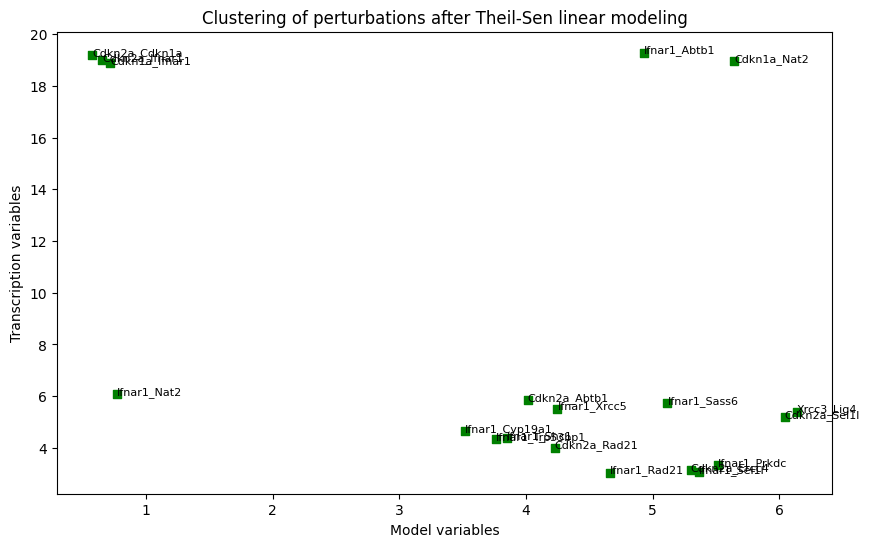

In [121]:
# Now, condense the coefficient variables to one dimension, the transcription variables to another,
# and plot them using UMAP.
clustering_variables = [
    "dominance", "magnitude", "dcor_predicted_actual", 
    "dcor_X_predicted", "dcor_x1_x2", "equality_of_contribution"
]
clustering_df = results_df[clustering_variables]

# Normalize to the same range
for variable in clustering_variables:
    std = clustering_df.loc[clustering_df.index[:], variable].std()
    clustering_df.loc[clustering_df.index[:], variable] = clustering_df.loc[clustering_df.index[:], variable] / std


# Reduce dimensionality using PCA and then project using UMAP
model_variables = clustering_df[["dominance", "magnitude", "dcor_predicted_actual"]]
transcription_variables = clustering_df[["dcor_X_predicted", "dcor_x1_x2", "equality_of_contribution"]]

reducer = umap.UMAP(n_components=1, n_neighbors=5, min_dist=0.05, spread=0.5)
model_umap_embedding = reducer.fit_transform(model_variables)
transcription_umap_embedding = reducer.fit_transform(transcription_variables)

embeddings_df = pd.DataFrame(np.hstack((model_umap_embedding, transcription_umap_embedding)), 
                             columns=['UMAP_1', 'UMAP_2'], index=clustering_df.index)

def plot_embeddings_scatter(df):
    plt.figure(figsize=(10, 6))
    points_ts = plt.scatter(df['UMAP_1'], df['UMAP_2'], color='green', marker='s')
    
    texts = []
    for idx in df.index:
        texts.append(plt.text(df.loc[idx, 'UMAP_1'], df.loc[idx, 'UMAP_2'], idx, color='black', fontsize=8))
    
    # adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1.5))
    
    plt.xlabel('Model variables')
    plt.ylabel('Transcription variables')
    plt.title('Clustering of perturbations after Theil-Sen linear modeling')
    plt.show()
plot_embeddings_scatter(embeddings_df)

## Pyturbseq analysis

In [123]:
# Try analyzing the same data but with pyturbseq instead. There shouldn't be any major
# differences in the modeling, but doesn't hurt to try and get some other analysis out of the way
# too. Turns out there ARE major differences, most notably in what we normalize all of the cells to.
# Normalizing to the non-targeting cells in this case does NOT work.

In [149]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.sparse as sp
from pyturbseq.utils import filter_adata
from pyturbseq.interaction import fit_many_parallel
import scrublet as scr
from pathlib import Path
%matplotlib inline

In [42]:
data_dir = "../../data"

In [43]:
data = sc.read_h5ad(os.path.join(data_dir, "simplified_seurat.h5ad"))

In [228]:
source = "preinf"
condition = "noRT"
output_dir = f"../../output/coefficient_analysis/{source}_{condition}"
sc._settings.ScanpyConfig.figdir = Path(output_dir)
subset_data = data[data.obs.sourceCond == f"{source}_{condition}"]
subset_data

View of AnnData object with n_obs × n_vars = 16598 × 32289
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'source', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'scMRMA', 'scMRMA_manual', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sourceCond', 'sgRNACond', 'double', 'percent_mt'
    var: 'features'

Processing GL261_noRT_preinf
Number of cells (275, 32289)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.24
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 11.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 30.8%
Elapsed time: 0.3 seconds


/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/3046272384.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs['predicted_doublets'] = predicted_doublets
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Processing GL261_noRT_preinf_MACSFACS_1
Number of cells (5720, 32289)
Preprocessing...


/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.5%
Elapsed time: 13.1 seconds


/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/3046272384.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs['predicted_doublets'] = predicted_doublets
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Processing GL261_noRT_preinf_MACSFACS_2
Number of cells (5413, 32289)
Preprocessing...


/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.0%
Elapsed time: 12.5 seconds


/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/3046272384.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs['predicted_doublets'] = predicted_doublets
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Processing GL261_noRT_preinf_MACSFACS_3
Number of cells (5190, 32289)
Preprocessing...


/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.3%
Elapsed time: 13.6 seconds


/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/3046272384.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs['predicted_doublets'] = predicted_doublets
/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


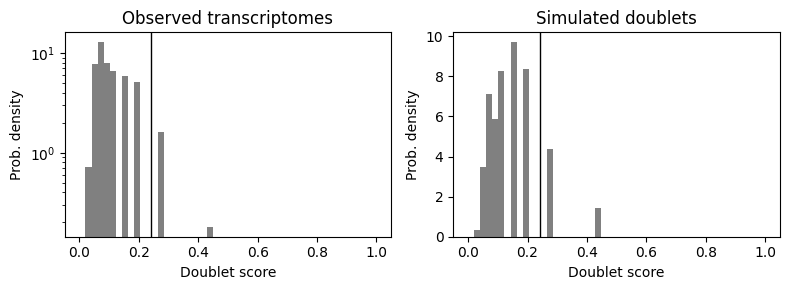

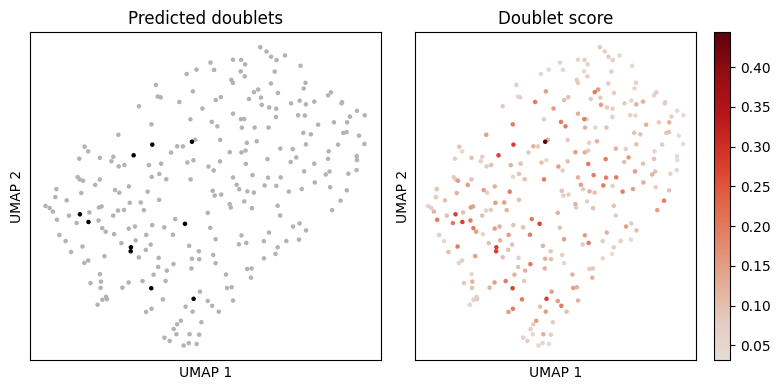

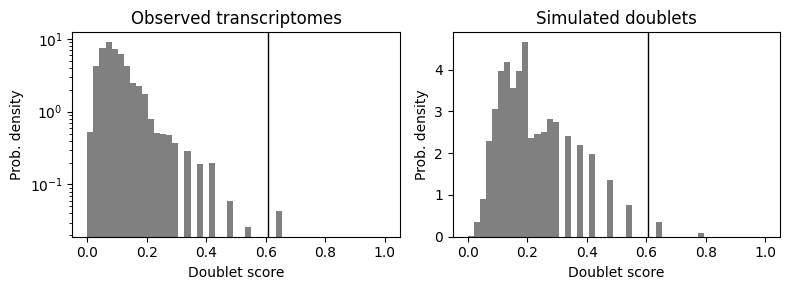

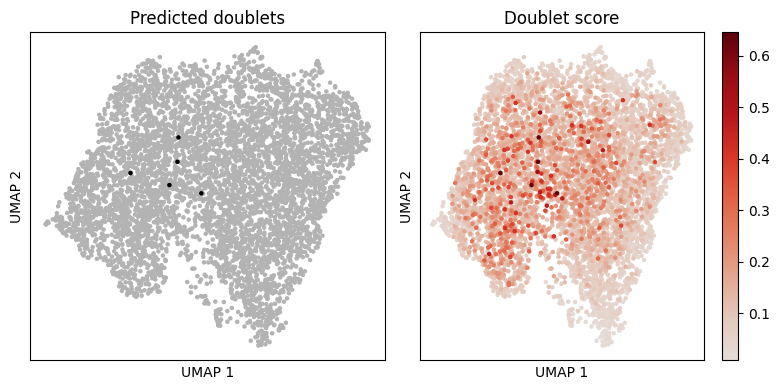

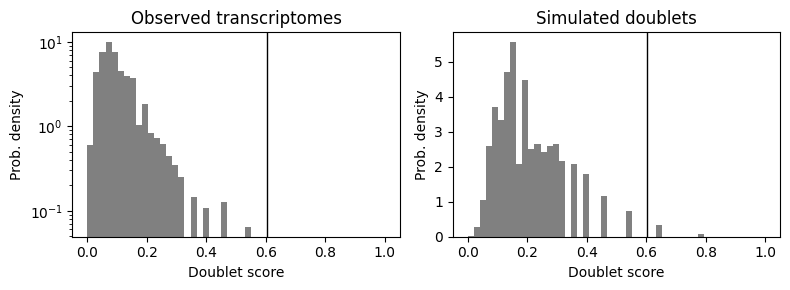

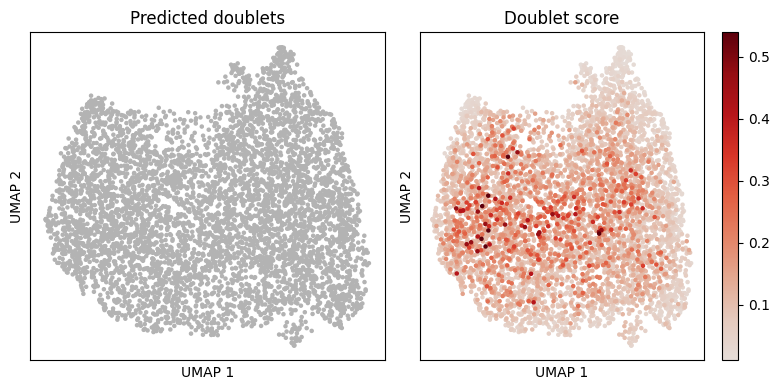

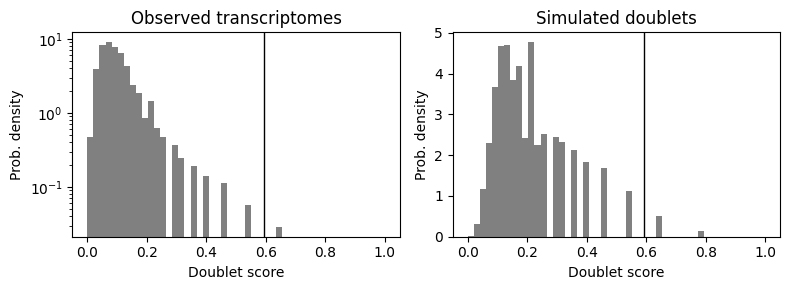

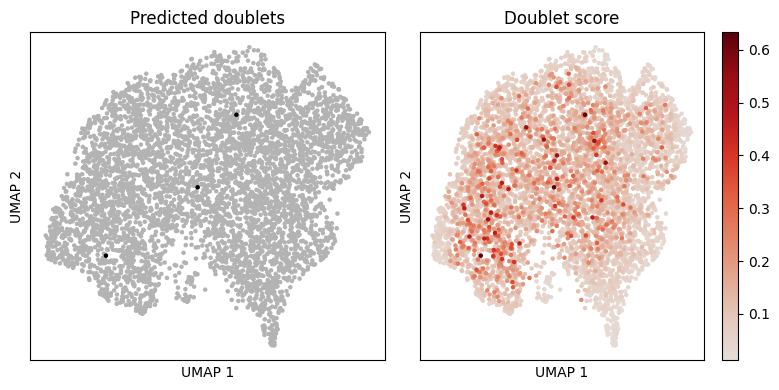

In [229]:
# Perform doublet detection for each of the samples
samples = np.unique(subset_data.obs[["orig.ident"]])
subsets = {}
for sample in samples:
    print(f"Processing {sample}")
    subset = subset_data[subset_data.obs["orig.ident"] == sample]
    print(f"Number of cells {subset.X.shape}")
    scrub = scr.Scrublet(subset.X, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)
    subset.obs['predicted_doublets'] = predicted_doublets
    subset.obs['doublet_scores'] = doublet_scores
    subsets[sample] = subset
    scrub.plot_histogram()
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
    scrub.plot_embedding('UMAP', order_points=True)

In [230]:
# Combine all of the obs for doublets together and see if they line up with the double cells
data_list = []
for name, adata in subsets.items():
    df = adata.obs[["predicted_doublets", "doublet_scores"]].copy()
    df["cell_name"] = adata.obs_names
    df["dataset"] = name
    data_list.append(df)
combined_df = pd.concat(data_list)

In [231]:
merged_obs = subset_data.obs.merge(combined_df, left_index=True, right_index=True, how='left')
subset_data.obs = merged_obs

In [232]:
crosstab = pd.crosstab(subset_data.obs['double'], subset_data.obs['predicted_doublets'])
crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
crosstab_percent

predicted_doublets      False     True 
double                                 
double              99.598394  0.401606
single              99.900621  0.099379

In [233]:
subset_data.obs['predicted_doublets'].value_counts()

predicted_doublets
False    16580
True        18
Name: count, dtype: int64

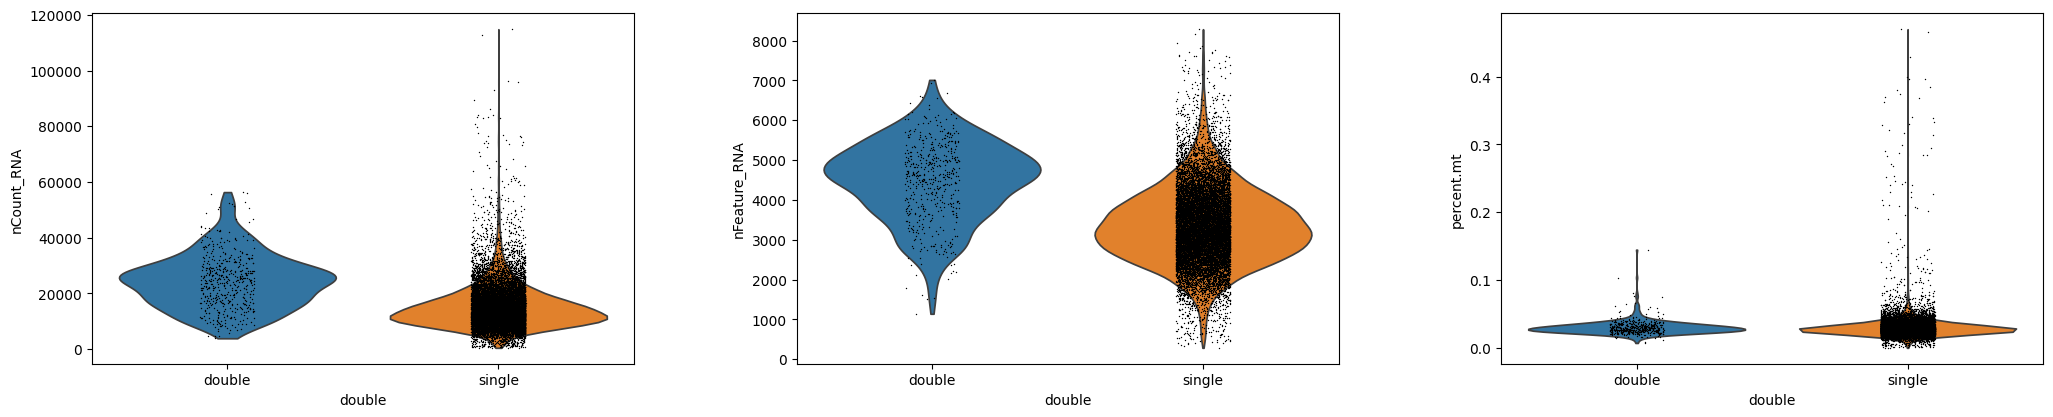

In [234]:
# Plot the QC metrics
subset_data
sc.pl.violin(subset_data, ['nCount_RNA', 'nFeature_RNA', 'percent.mt'], groupby="double", stripplot=True, save="qc_metrics.pdf")

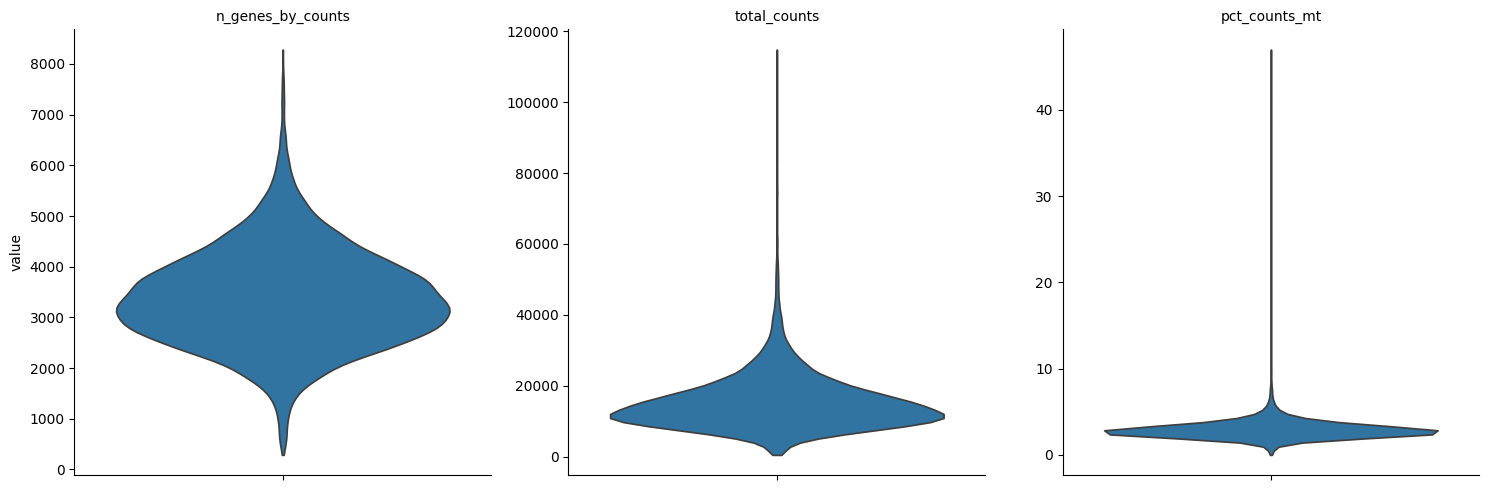

In [235]:
# Filter the cells by QC metrics from Scanpy
subset_data.var['mt'] = subset_data.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(subset_data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(subset_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], stripplot=False, multi_panel=True)

In [236]:
subset_data = filter_adata(
    subset_data,
    obs_filters=[
        "n_genes_by_counts > 2000",
        "pct_counts_mt < 20",
        "total_counts > 6000",
    ],
    var_filters=[
        'n_cells_by_counts > 50',
        'total_counts > 100'
    ]
    )
subset_data

View of AnnData object with n_obs × n_vars = 15552 × 12780
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'source', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'scMRMA', 'scMRMA_manual', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sourceCond', 'sgRNACond', 'double', 'percent_mt', 'predicted_doublets', 'doublet_scores', 'cell_name', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'double_colors'

In [237]:
# Do a coverage check for each sgRNA. We will eliminate any sgRNA from consideration
# that doesn't have at least 5 cells in both single and combination
mask = subset_data.obs.sgRNA.str.contains("_")
combinations = subset_data.obs.sgRNA[mask]
sgRNAs_to_keep = ["non-targeting"] # Keep non-targeting by default for normalization
sgRNA_counts = subset_data.obs.sgRNA.value_counts()
for combination in combinations:
    geneA = combination.split("_")[0]
    geneB = combination.split("_")[1]
    if sgRNA_counts[combination].item() > 5 and sgRNA_counts[geneA].item() > 5 and sgRNA_counts[geneB].item() > 5:
        sgRNAs_to_keep.extend([geneA, geneB, combination])
subset_data = subset_data[subset_data.obs.sgRNA.isin(sgRNAs_to_keep)].copy()
subset_data

AnnData object with n_obs × n_vars = 15167 × 12780
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'source', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'scMRMA', 'scMRMA_manual', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sourceCond', 'sgRNACond', 'double', 'percent_mt', 'predicted_doublets', 'doublet_scores', 'cell_name', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'double_colors'

In [238]:
# Process subset_data so that its perturbations look like what we expect
def modify_sgRNA(sgRNA):
    if sgRNA == "non-targeting":
        return "NTC"
    elif "_" in sgRNA:
        return sgRNA.replace("_", "|")
    else:
        return sgRNA
subset_data.obs["perturbation"] = subset_data.obs["sgRNA"].apply(modify_sgRNA)
print(subset_data.obs[['sgRNA', 'perturbation']])

                                sgRNA    perturbation
AAACGAAAGCTGAAAT-1_9           Ifnar1          Ifnar1
AAACGAAGTGCTGTCG-1_9            Fanca           Fanca
AAATGGAAGCAGCGAT-1_9           Cdkn1a          Cdkn1a
AAATGGACATATAGCC-1_9           Ifnar1          Ifnar1
AACGTCAAGCTGACTT-1_9           Cdkn1a          Cdkn1a
...                               ...             ...
TTTGGTTTCAACTACG-1_12         Cyp19a1         Cyp19a1
TTTGGTTTCATTGGTG-1_12          Ifnar1          Ifnar1
TTTGGTTTCTCTATGT-1_12          Cdkn2a          Cdkn2a
TTTGTTGCACCAAAGG-1_12           Abtb1           Abtb1
TTTGTTGTCTAGAACC-1_12  Ifnar1_Cyp19a1  Ifnar1|Cyp19a1

[15167 rows x 2 columns]


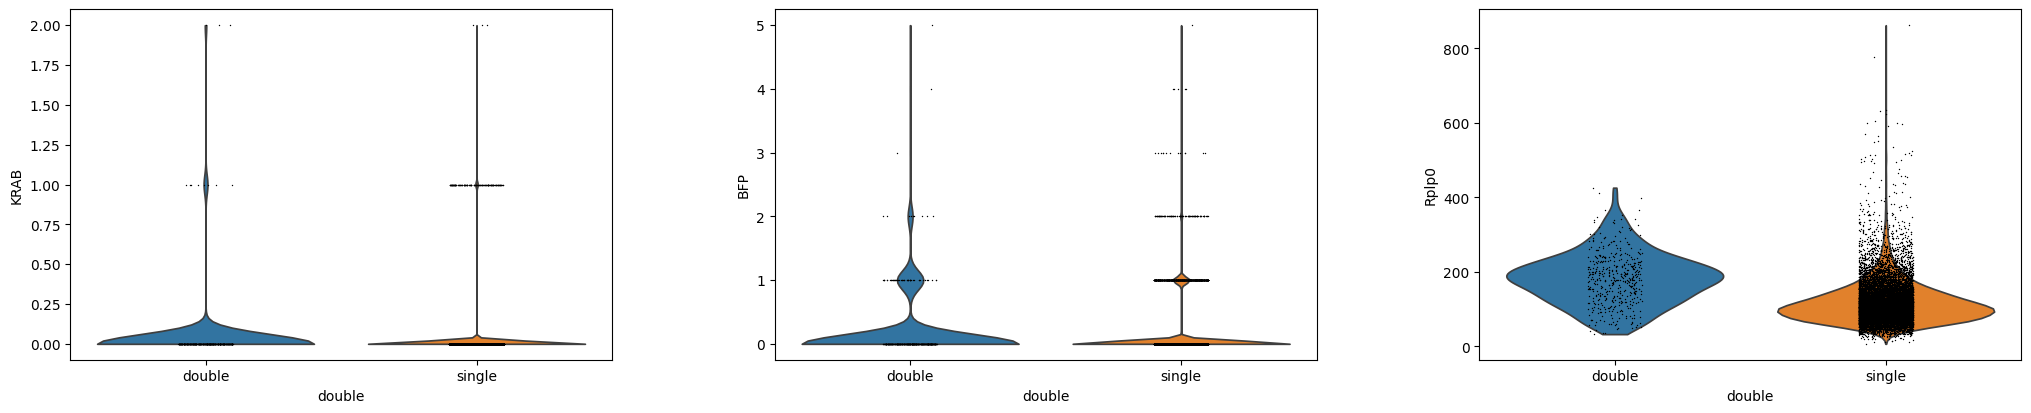

In [239]:
# Do some additional checks for doublets. What if we plot violin plots of Krab and Bfp?
sc.pl.violin(
    subset_data,
    keys=["KRAB", "BFP", "Rplp0"],
    groupby="double",
    use_raw=False,
    stripplot=True,
    save="krab_bfp_rplp0_plot.pdf"
)

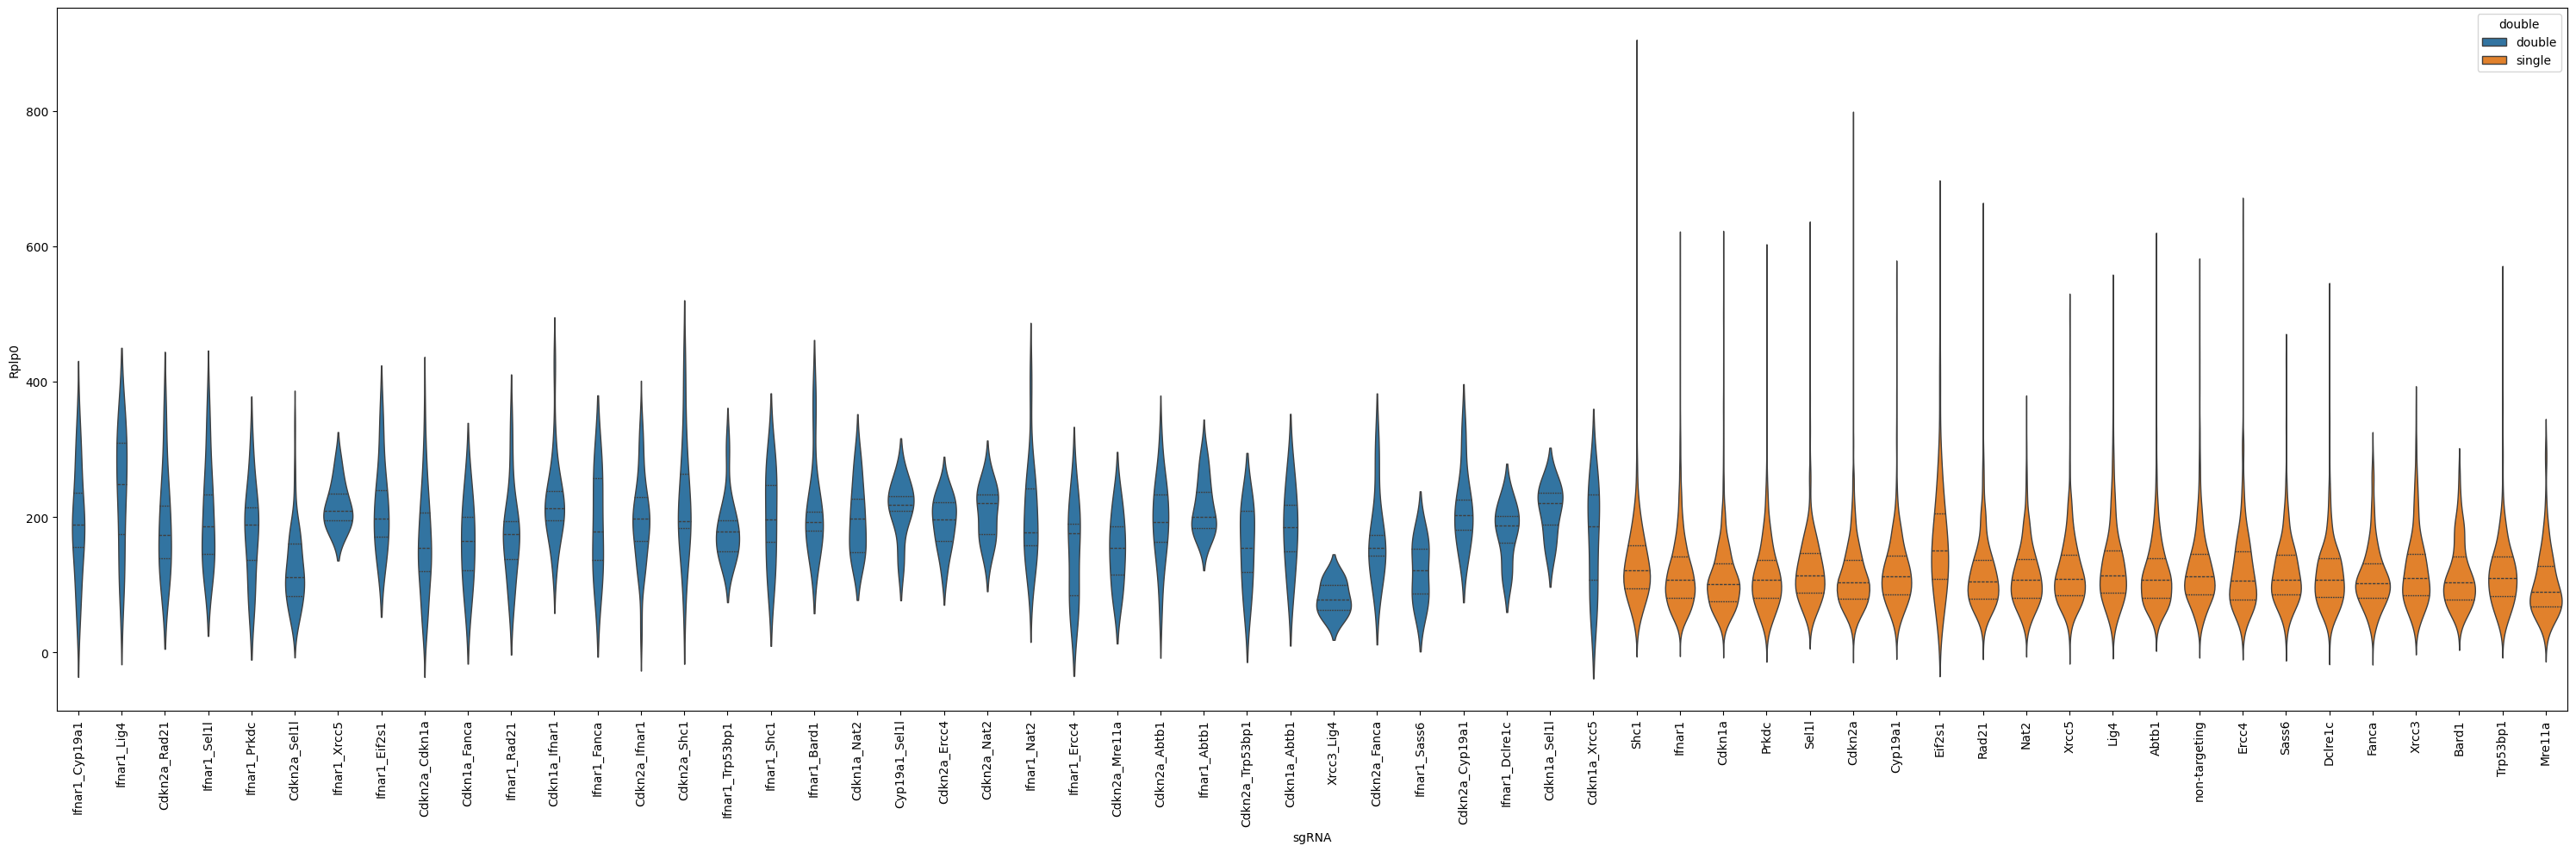

In [240]:
# Split the violin plots by doubles and group them by perturbation
df = sc.get.obs_df(subset_data, ["Rplp0", "double", "sgRNA"])
df.sort_values("double", inplace=True)
plt.figure(figsize=(30, 10))
sns.violinplot(data=df, x="sgRNA", y="Rplp0", hue="double", inner="quart", linewidth=1, order=df["sgRNA"].unique())
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "rplp0_split_violin_plot.pdf"))
plt.show()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/2563767497.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Double', bbox_to_anchor=(1.05, 1), loc='upper left')


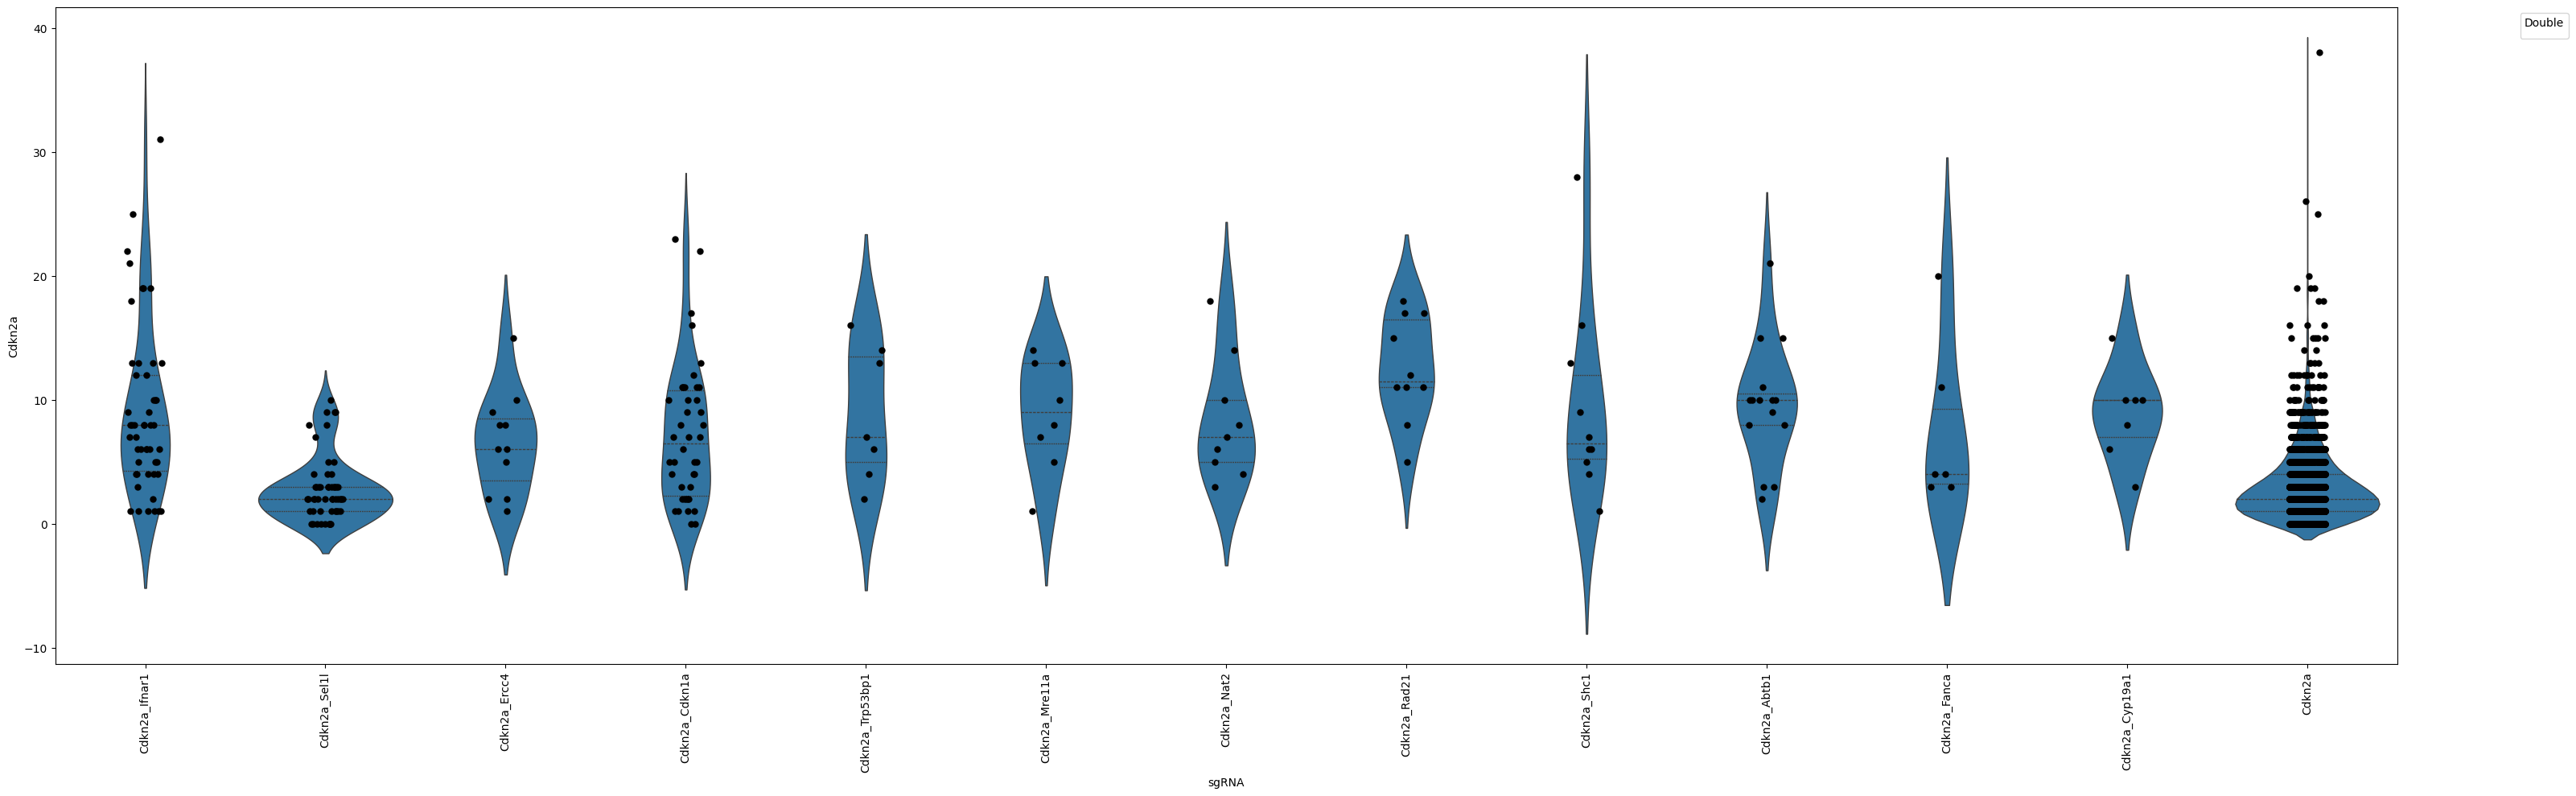

In [241]:
# Split the violin plots by doubles and group them by perturbation
df = sc.get.obs_df(subset_data, ["Cdkn2a", "double", "sgRNA"])
df = df[df["sgRNA"].str.contains("Cdkn2a", na=False)]
df.sort_values("double", inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(30, 10), sharex=True)
sns.violinplot(data=df, 
               x="sgRNA", 
               y="Cdkn2a", 
               inner="quart", 
               order=df["sgRNA"].unique(),
              linewidth=1)
sns.stripplot(data=df,
              x="sgRNA",
              y="Cdkn2a",
              color="black",
              order=df["sgRNA"].unique(),
              linewidth=1)
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
plt.legend(title='Double', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(os.path.join(output_dir, "cdkn2a_split_violin_plot.pdf"))
plt.show()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/1069103953.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="center")
/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/1069103953.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="center")
/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/1069103953.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="center")
/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_40382/1069103953.py:26: UserWarning: set_ticklabels() should only be us

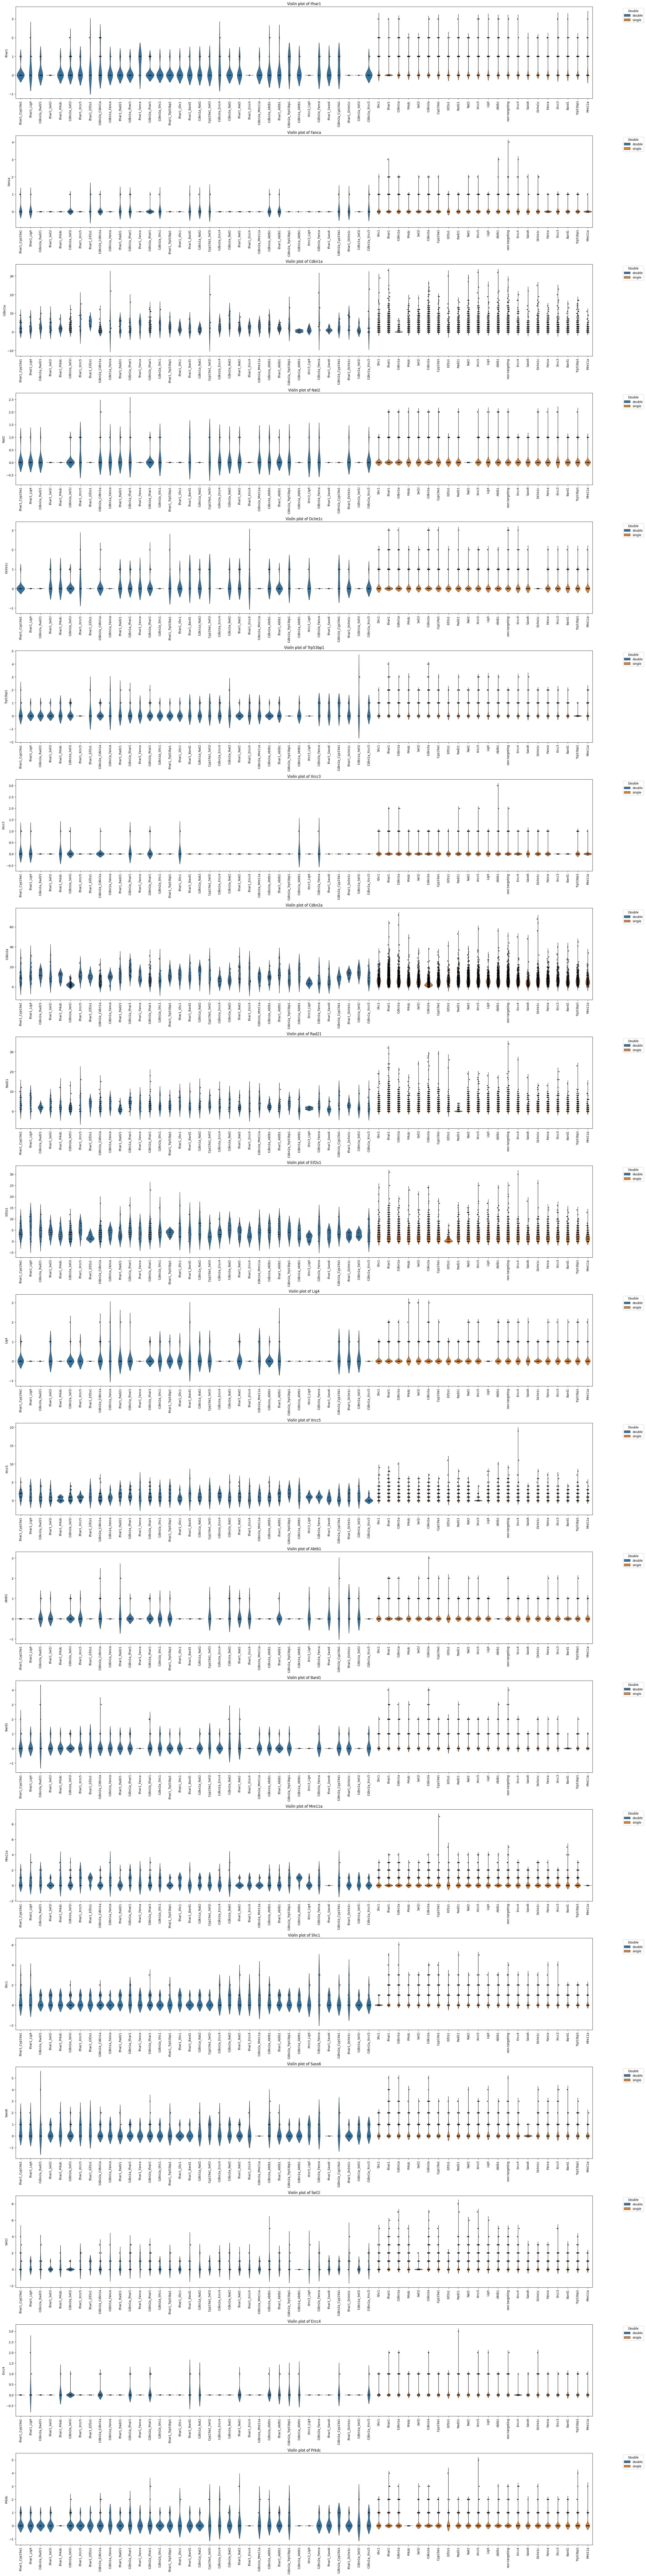

In [251]:
# Plot stacked violin plots for each of the knockout genes
df = sc.get.obs_df(subset_data, ["double", "sgRNA"])
knockout_genes = [i for i in df["sgRNA"].unique() if i != "non-targeting" and "_" not in i and i in subset_data.var_names]
df = sc.get.obs_df(subset_data, ["double", "sgRNA"] + knockout_genes)
df.sort_values("double", inplace=True)

# Create subplots
num_genes = len(knockout_genes)
fig, axes = plt.subplots(num_genes, 1, figsize=(30, 6 * num_genes), sharex=False)
for i, gene in enumerate(knockout_genes):
    sns.violinplot(
        data=df,
        x="sgRNA",
        y=gene,
        hue="double",
        inner="quart",
        linewidth=1,
        order=df["sgRNA"].unique(),
        ax=axes[i]
    )
    sns.stripplot(x="sgRNA", y=gene, color="black", data=df, size=3, jitter=True, zorder=1, ax=axes[i], order=df["sgRNA"].unique())
    axes[i].set_title(f"Violin plot of {gene}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(gene)
    axes[i].legend(title="Double", bbox_to_anchor=(1.05, 1), loc="upper left")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "stacked_violin_plots.pdf"), dpi=300, bbox_inches='tight')
plt.show()

In [78]:
sc.pp.normalize_total(subset_data)
subset_data

AnnData object with n_obs × n_vars = 15167 × 12780
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'source', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'scMRMA', 'scMRMA_manual', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sourceCond', 'sgRNACond', 'double', 'percent_mt', 'predicted_doublets', 'doublet_scores', 'cell_name', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'perturbation'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'double_colors'

In [297]:
# Pseudobulk the cells by taking an average
def aggregate_by_perturbation(data, column="perturbation"):
    """
    Aggregate an Anndata object by a particular column and take the average for all cells
    """
    if column not in data.obs.columns:
        return ValueError(f"Column does not exist")

    unique_perturbations = data.obs[column].unique()
    pseudobulk_data = []
    pseudobulk_obs = []
    for group in unique_perturbations:
        subset = data[data.obs[column] == group]
        if sp.issparse(subset.X):
            mean_expr = np.array(subset.X.mean(axis=0)).flatten()
        else:
            mean_expr = np.mean(subset.X, axis=0)
        pseudobulk_data.append(mean_expr)
        pseudobulk_obs.append({column: group})

    pseudobulk_adata = anndata.AnnData(
        X=np.array(pseudobulk_data),
        obs=pd.DataFrame(pseudobulk_obs),
        var=data.var
    )
    return pseudobulk_adata

In [298]:
pb = aggregate_by_perturbation(subset_data, "perturbation")
pb

/Users/christopher/Library/Caches/pypoetry/virtualenvs/genome-biology-methods-_cE-HaLl-py3.11/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4 × 10447
    obs: 'perturbation'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [299]:
# Get combinations
mask = pb.obs.perturbation.str.contains("\|")
combinations = pd.unique(pb.obs.perturbation[mask])
combinations

array(['Lmo7|Eif2s1'], dtype=object)

In [300]:
def modify_sgRNA(sgRNA):
    if "|" in sgRNA:
        return sgRNA
    else:
        return "|".join(sorted(["NTC", sgRNA]))
pb.obs["perturbation"] = pb.obs["perturbation"].apply(modify_sgRNA)
pb.obs.index = pb.obs.perturbation
pb.obs

perturbation
perturbation             
NTC|NTC           NTC|NTC
Eif2s1|NTC     Eif2s1|NTC
Lmo7|NTC         Lmo7|NTC
Lmo7|Eif2s1   Lmo7|Eif2s1

In [301]:
res = fit_many_parallel(pb, combinations, processes = 8)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.01s/it]


Found AnnData, densifying to df. This may take a while... 


In [302]:
res.to_csv(os.path.join(output_dir, "pseudobulked_average_pyturbseq_results.csv"))

In [303]:
res.loc[:, ["coef_a", "coef_b", "dcor_AB_fit", "score", "fit_spearmanr", "fit_pearsonr"]]

coef_a    coef_b  dcor_AB_fit     score  fit_spearmanr  \
perturbation                                                             
Lmo7|Eif2s1   0.380211  0.400265     0.977546  0.846581       0.896893   

              fit_pearsonr  
perturbation                
Lmo7|Eif2s1       0.981221

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_27665/3903274838.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


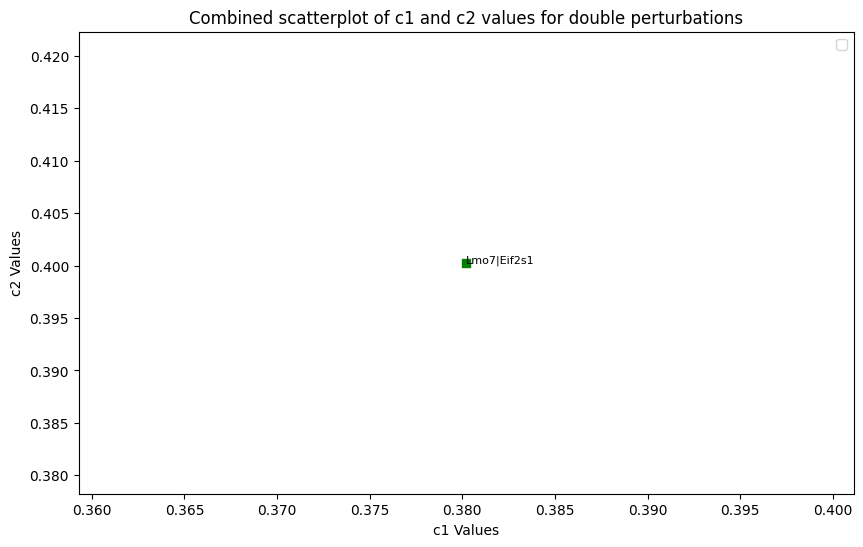

In [304]:
# Plot these results!
def plot_combined_scatter(df):
    plt.figure(figsize=(10, 6))
    points_ts = plt.scatter(df['coef_a'], df['coef_b'], color='green', marker='s')
    
    texts = []
    for idx in df.index:
        texts.append(plt.text(df.loc[idx, 'coef_a'], df.loc[idx, 'coef_b'], idx, color='black', fontsize=8))
        
    plt.xlabel('c1 Values')
    plt.ylabel('c2 Values')
    plt.title('Combined scatterplot of c1 and c2 values for double perturbations')
    plt.legend()
    plt.savefig(os.path.join(output_dir, "pyturbseq_pseudobulked_average_combined_scatter.png"))
    plt.show()
plot_combined_scatter(res)

In [305]:
# Now, condense the coefficient variables to one dimension, the transcription variables to another,
# and plot them using UMAP.
clustering_variables = [
    "abs_log10_ratio_coefs", "coef_norm2", "dcor_AB_fit", 
    "dcor_AnB_fit", "dcor_A_B", "dcor_ratio"
]
clustering_df = res[clustering_variables]

# Normalize to the same range
for variable in clustering_variables:
    std = clustering_df.loc[clustering_df.index[:], variable].std()
    clustering_df.loc[clustering_df.index[:], variable] = clustering_df.loc[clustering_df.index[:], variable] / std


# Reduce dimensionality using PCA and then project using UMAP
model_variables = clustering_df[["abs_log10_ratio_coefs", "coef_norm2", "dcor_AB_fit"]]
transcription_variables = clustering_df[["dcor_AnB_fit", "dcor_A_B", "dcor_ratio"]]

reducer = umap.UMAP(n_components=1, n_neighbors=5, min_dist=0.05, spread=0.5)
model_umap_embedding = reducer.fit_transform(model_variables)
transcription_umap_embedding = reducer.fit_transform(transcription_variables)

embeddings_df = pd.DataFrame(np.hstack((model_umap_embedding, transcription_umap_embedding)), 
                             columns=['UMAP_1', 'UMAP_2'], index=clustering_df.index)

def plot_embeddings_scatter(df):
    plt.figure(figsize=(10, 6))
    points_ts = plt.scatter(df['UMAP_1'], df['UMAP_2'], color='green', marker='s')
    
    texts = []
    for idx in df.index:
        texts.append(plt.text(df.loc[idx, 'UMAP_1'], df.loc[idx, 'UMAP_2'], idx, color='black', fontsize=8))
    
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1.5))
    
    plt.xlabel('Model variables')
    plt.ylabel('Transcription variables')
    plt.title('Clustering of perturbations after Theil-Sen linear modeling')
    plt.savefig(os.path.join(output_dir, "pyturbseq_pseudobulked_average_clustering.png"))
    plt.show()
plot_embeddings_scatter(embeddings_df)

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_27665/1683611716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df.loc[clustering_df.index[:], variable] = clustering_df.loc[clustering_df.index[:], variable] / std


ValueError: Input contains NaN.

In [ ]:
# Given a noRT and an RT dataframe, plot on the same plot with different colors. Draw lines between the same perturbations